In [1]:
# Version 1.0
# Here we try logistic regression on raw data and processed data
# Here we try graident boosting on raw adta and processed data
# we tune hyperparameters in order to find the highest auc score

In [2]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, ensemble
from sklearn import model_selection
from xgboost import XGBClassifier
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
def read_file(filename):
    '''
    input: the file path
    function: read in csv file
    return: dataframe type of data
    '''
    raw_data = pd.read_csv(filename)
    data = raw_data.copy()
    return data

In [4]:
# tries about dropping features (same_response_features/allocation_features)

def select_same_resp_feature(X):
    '''
    input: dataframe X
    function: find out same response features
    output: list of same response features
    '''
    same_resp_feature = []
    for feature in X.columns:
        if len(np.unique(X[feature])) == 1:
            same_resp_feature.append(feature)
    print(len(same_resp_feature))
    return same_resp_feature

def select_allocation_flag(X):
    '''
    input: dataframe X
    function: find out all the allocation_flag features
    output: list of allocation_flag features
    '''
    allocation_flag_feature = []
    for feature in X.columns:
        if feature[:2] == 'PX' or feature[:2] == 'HX':
            #print(feature)
            allocation_flag_feature.append(feature)
    other_alloc = ['PRCITFLG', 'PRWERNAL', 'PRHERNAL']
    allocation_flag_feature = allocation_flag_feature + other_alloc
    print(len(allocation_flag_feature))
    return allocation_flag_feature

def drop_features(X):
    '''
    input: dataframe X
    function: wrapper on dropping undesired features in place.
    '''
    same_resp_feature = select_same_resp_feature(X)
    allocation_flag_feature = select_allocation_flag(X)
    drop_features = list(set(same_resp_feature + allocation_flag_feature))
    X.drop(drop_features, axis=1, inplace=True)
    print(X.shape)
    

In [5]:
def train_data_preprocessing(filename):
    # read in the train file
    train_data = read_file(filename)
    y_train = train_data['target']
    X_train_raw = train_data.drop(['target', 'id'], axis=1)

    # no dropping raw data -> np array
    X_train_raw_arr = X_train_raw.values
    y_train_arr = y_train.values
    
    # drop features -> np array
    to_drop_features = select_same_resp_feature(X_train_raw)
    X_train_drop = X_train_raw.drop(to_drop_features, axis=1)
    X_train_drop_arr = X_train_drop.values
    
    return X_train_raw_arr, y_train_arr, X_train_drop_arr, to_drop_features

def test_data_preprocessing(filename, to_drop_features):
    test_data = read_file(filename)
    X_test_raw = test_data.drop(['id'], axis=1)
    X_test_raw_arr = X_test_raw.values

    X_test_drop = X_test_raw.drop(to_drop_features, axis=1)
    X_test_drop_arr = X_test_drop.values
    
    return X_test_raw_arr, X_test_drop_arr

In [6]:
# raw pd.dataframe data
train_path = "train_2008.csv"
test_path = "test_2008.csv"
train_data = read_file(train_path)
test_data = read_file(test_path)

y_train = train_data['target']
X_train = train_data.drop(['target', 'id'], axis=1)
X_test = test_data.drop('id', axis=1)

In [7]:
# drop same response features
same_resp_feature = select_same_resp_feature(X_train)
X_train.drop(same_resp_feature, axis=1, inplace=True)
X_test.drop(same_resp_feature, axis=1, inplace=True)
print(same_resp_feature)

15
['HRMONTH', 'HRYEAR4', 'HUTYPEA', 'HUTYPC', 'HRINTSTA', 'PEAFNOW', 'PRPERTYP', 'PULKDK4', 'PULKDK5', 'PULKDK6', 'PULKPS4', 'PULKPS5', 'PULKPS6', 'HXPHONEO', 'PXAGE']


In [8]:
# map negative response to -1
for feature in X_train.columns:
    X_train[feature] = X_train[feature].apply(lambda x: -1 if x < 0 else x)
    X_test[feature] = X_test[feature].apply(lambda x: -1 if x < 0 else x)

In [9]:
# categorical features (one-hot encoding)
categorical_features = ['HUFINAL','GEREG', 'HUBUS', 'PTDTRACE', 'PENATVTY', 'PUABSOT', 'PEIO1COW', 
                        'HUFINAL', 'GESTCEN', 'GESTFIPS', 'PRCITSHP', 'PUDIS', 'PRABSREA', 'PRWKSTAT', 'HUPRSCNT', 
                        'PERRP', 'GTCBSAST', 'PRMJOCGR', 'HRHTYPE', ]
train_dummy = pd.DataFrame()
test_dummy = pd.DataFrame()
for feature in categorical_features:
    train_dummy_tmp = pd.get_dummies(X_train[feature], prefix=feature)
    train_dummy = pd.concat([train_dummy, train_dummy_tmp], axis=1)
    test_dummy_tmp = pd.get_dummies(X_test[feature], prefix=feature)
    test_dummy = pd.concat([test_dummy, test_dummy_tmp], axis=1)
X_train.drop(categorical_features, axis=1, inplace=True)
X_test.drop(categorical_features, axis=1, inplace=True)
X_train = pd.concat([X_train, train_dummy], axis=1)
X_test = pd.concat([X_test, test_dummy], axis=1)

In [10]:
train_add_features = [f for f in X_test.columns if f not in X_train.columns]
test_add_features = [f for f in X_train.columns if f not in X_test.columns]

for feature in train_add_features:
    X_train[feature] = 0
for feature in test_add_features:
    X_test[feature] = 0

In [11]:
X = X_train.values
Y = y_train.values
X_t = X_test.values
print(X.shape)
print(Y.shape)
print(X_t.shape)

(64667, 749)
(64667,)
(16000, 749)


In [12]:
def cross_validation(X, num_folds, clf):
    kf = model_selection.KFold(n_splits=num_folds)
    train_auc_ls = []
    valid_auc_ls = []
    for train_index, valid_index in kf.split(X):
        print("1...")
        print("TRAIN:", train_index, "VALIDATION:", valid_index)
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = Y[train_index], Y[valid_index]
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict_proba(X_train)[:, 1]
        y_valid_pred = clf.predict_proba(X_valid)[:, 1]
        train_auc = metrics.roc_auc_score(y_train, y_train_pred)
        valid_auc = metrics.roc_auc_score(y_valid, y_valid_pred)
        train_auc_ls.append(train_auc)
        valid_auc_ls.append(valid_auc)
        print("2...")
    return train_auc_ls, valid_auc_ls, clf

In [13]:
# logistic regression
# raw data for logistic regression
# tune the hyperparameter C has little influence
# current C =  0.3 , auc =  [0.7663607035376859, 0.7721732996821118, 0.7687268216387099]
# current C =  0.475 , auc =  [0.7662418721269123, 0.7712735791351473, 0.768680422577126]
# current C =  0.6499999999999999 , auc =  [0.7661768150447318, 0.7713118201969408, 0.7683741910137993]
# current C =  0.825 , auc =  [0.7661509304142629, 0.7711936392253098, 0.7682658368117301]
# current C =  1.0 , auc =  [0.766072324965325, 0.7707366180248577, 0.7682738111247072]
# X_train_raw_arr, y_train_raw_arr, X_train_drop_arr = data_preprocessing(train_path, to_drop_features)
# X_test_raw_arr, y_test_raw_arr, X_test_drop_arr = data_preprocessing(test_path, to_drop_features)
# num_folds = 3
# C_para = np.linspace(0.3, 1, 5)
# for C in C_para:
#     auc = logistic_reg(X_train_raw_arr, num_folds, C)
#     print("current C = ", C, ", auc = ", auc)

In [14]:
# run logistic regression
num_folds = 3
#C = 0.3
C_values = [0.2, 0.3, 0.4, 0.5, 0.6]
print(C_values)
valid_auc = []
for C in C_values:
    clf = linear_model.LogisticRegression(penalty='l1', C=C, solver='liblinear')
    train_auc_ls, valid_auc_ls, clf = cross_validation(X, num_folds, clf)
    valid_auc.append(np.mean(valid_auc_ls))

[0.2, 0.3, 0.4, 0.5, 0.6]
1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 64665 64666]
2...
1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [43112 43113 43114 ... 64664 64665 64666]
2...
1...
TRAIN: [21556 21557 21558 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 21553 21554 21555]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [21556 21557 21558 ... 43109 43110 43111]
2...
1...
TRAIN: [    0     1     2 ... 43109 43110 43111] VALIDATION: [431

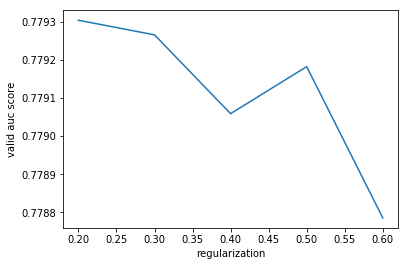

In [15]:
plt.figure()
plt.plot(C_values, valid_auc)
plt.xlabel("regularization")
plt.ylabel("valid auc score")
plt.show()

In [16]:
# run gbdt
num_folds = 5
num_estimators = range(30, 100, 10)
valid_auc = []
for num in num_estimators:
    clf = ensemble.GradientBoostingClassifier(n_estimators=num, random_state=10, min_samples_leaf=20) 
    train_auc_ls, valid_auc_ls, clf = cross_validation(X, num_folds, clf)
    valid_auc.append(np.mean(valid_auc_ls))

1...
TRAIN: [12934 12935 12936 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 12931 12932 12933]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [12934 12935 12936 ... 25865 25866 25867]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [25868 25869 25870 ... 38798 38799 38800]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [38801 38802 38803 ... 51731 51732 51733]
2...
1...
TRAIN: [    0     1     2 ... 51731 51732 51733] VALIDATION: [51734 51735 51736 ... 64664 64665 64666]
2...
1...
TRAIN: [12934 12935 12936 ... 64664 64665 64666] VALIDATION: [    0     1     2 ... 12931 12932 12933]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [12934 12935 12936 ... 25865 25866 25867]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [25868 25869 25870 ... 38798 38799 38800]
2...
1...
TRAIN: [    0     1     2 ... 64664 64665 64666] VALIDATION: [38801 38802 38803 ... 51731 5

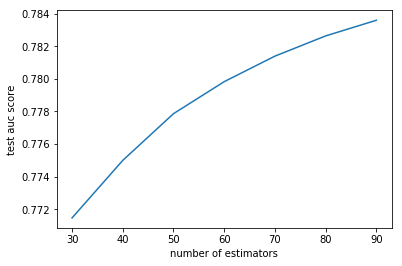

In [17]:
plt.figure()
plt.plot(num_estimators, valid_auc)
plt.xlabel("number of estimators")
plt.ylabel("test auc score")
plt.show()